In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

ee.Initialize()

print("Earth Engine initialized successfully.")

Earth Engine initialized successfully.


In [2]:
# Geometry for Kabul (reuse what you already had)
kabul_lat = 34.53
kabul_lon = 69.17

def make_city_bbox(lon, lat, half_deg=0.25):
    return ee.Geometry.Rectangle([
        lon - half_deg,
        lat - half_deg,
        lon + half_deg,
        lat + half_deg,
    ])

kabul_geom = make_city_bbox(kabul_lon, kabul_lat, half_deg=0.25)

# Sentinel-5P NO2 collection
no2_collection = (
    ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2")
    .select("tropospheric_NO2_column_number_density")
)

# Date range for 2023
start = ee.Date("2019-01-01")
end   = ee.Date("2025-01-01")  # end is exclusive; this covers up to 2024-12

In [3]:
# Number of months between start and end
n_months = end.difference(start, "month").int()

# List of month offsets: 0, 1, 2, ..., n_months-1
month_indices = ee.List.sequence(0, n_months.subtract(1))


def monthly_mean(m):
    m = ee.Number(m)
    start_m = start.advance(m, "month")
    end_m   = start_m.advance(1, "month")
    
    # Filter NO2 images to this month & region
    monthly_collection = (
        no2_collection
        .filterDate(start_m, end_m)
        .filterBounds(kabul_geom)
    )
    
    # Monthly mean image
    monthly_img = monthly_collection.mean()
    
    # Reduce to a single mean value over Kabul
    mean_dict = monthly_img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=kabul_geom,
        scale=1000,
        bestEffort=True
    )
    
    return ee.Feature(
        None,
        {
            "month_start": start_m.format("YYYY-MM-dd"),
            "no2": mean_dict.get("tropospheric_NO2_column_number_density"),
        },
    )

monthly_features = ee.FeatureCollection(month_indices.map(monthly_mean))
monthly_features


In [4]:
# Bring data from Earth Engine into local Python
monthly_dict = monthly_features.getInfo()
features = monthly_dict["features"]

rows = []
for f in features:
    props = f["properties"]
    rows.append({
        "month_start": props["month_start"],
        "no2": props["no2"],
    })

df = pd.DataFrame(rows)
df.head()


,month_start,no2
0,2019-01-01,0.000054
1,2019-02-01,0.000041
2,2019-03-01,0.000038
3,2019-04-01,0.000039
4,2019-05-01,0.000038


In [5]:
df = df.dropna(subset=["no2"]).copy()
df["month_start"] = pd.to_datetime(df["month_start"])
df = df.sort_values("month_start")
df

,month_start,no2
0,2019-01-01,0.000054
1,2019-02-01,0.000041
2,2019-03-01,0.000038
3,2019-04-01,0.000039
4,2019-05-01,0.000038
...,...,...
67,2024-08-01,0.000032
68,2024-09-01,0.000033
69,2024-10-01,0.000033
70,2024-11-01,0.000037


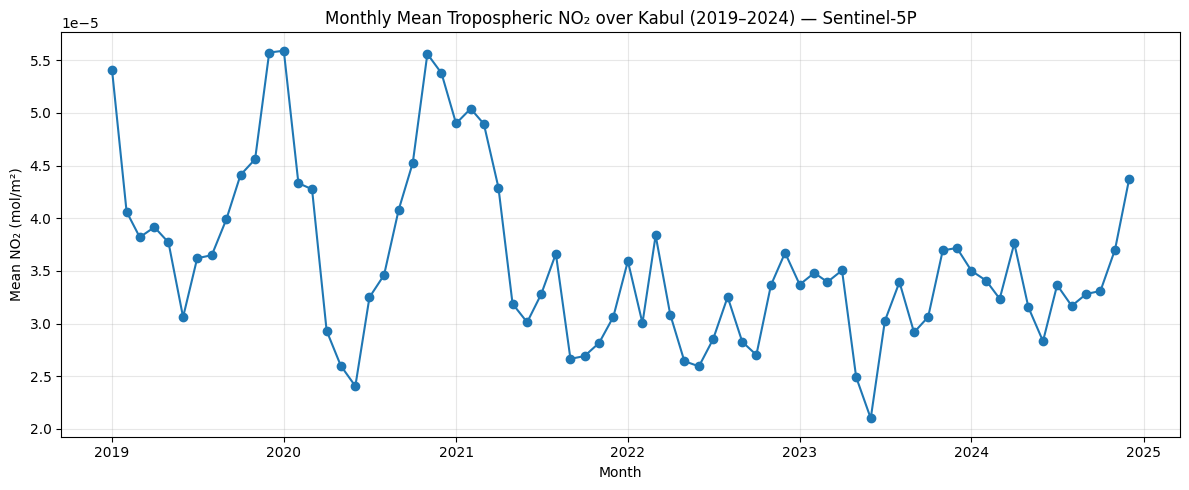

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df["month_start"], df["no2"], marker="o")

plt.title("Monthly Mean Tropospheric NO₂ over Kabul (2019–2024) — Sentinel-5P")
plt.xlabel("Month")
plt.ylabel("Mean NO₂ (mol/m²)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
df["year"] = df["month_start"].dt.year

annual = (
    df[df["year"].between(2019, 2024)]
    .groupby("year", as_index=False)["no2"]
    .mean()
)

annual

,year,no2
0,2019,0.000042
1,2020,0.000040
2,2021,0.000036
3,2022,0.000031
4,2023,0.000032
5,2024,0.000034


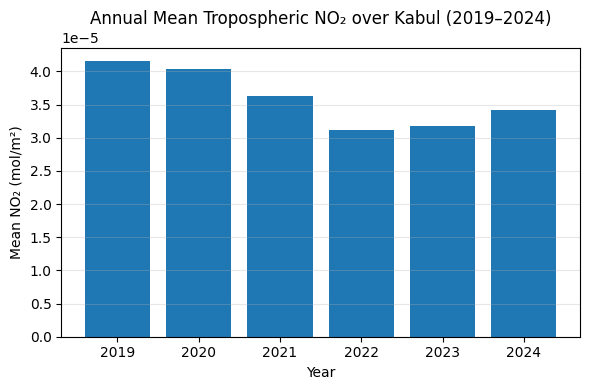

In [8]:
plt.figure(figsize=(6, 4))
plt.bar(annual["year"], annual["no2"])

plt.title("Annual Mean Tropospheric NO₂ over Kabul (2019–2024)")
plt.xlabel("Year")
plt.ylabel("Mean NO₂ (mol/m²)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation

This chart shows the monthly mean tropospheric NO₂ over Kabul in 2023, derived from Sentinel-5P. NO₂ is a proxy for combustion-related pollution (traffic, generators, heating). Higher values in colder months likely reflect increased fuel use and more stagnant air, while lower values in warmer months suggest better dispersion and less heating-related combustion.
